In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

correct_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
print(os.listdir(correct_path))

['train', 'val', 'test']


In [7]:
print("Train folders:", os.listdir(correct_path + '/train'))
print("Val folders:", os.listdir(correct_path + '/val'))
print("Test folders:", os.listdir(correct_path + '/test'))

Train folders: ['PNEUMONIA', 'NORMAL']
Val folders: ['PNEUMONIA', 'NORMAL']
Test folders: ['PNEUMONIA', 'NORMAL']


In [8]:
import os

base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'

splits = ['train', 'val', 'test']
classes = ['PNEUMONIA', 'NORMAL']

for split in splits:
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{split.capitalize()} - {cls}: {count} images")


Train - PNEUMONIA: 3818 images
Train - NORMAL: 1403 images
Val - PNEUMONIA: 1135 images
Val - NORMAL: 418 images
Test - PNEUMONIA: 1141 images
Test - NORMAL: 415 images


In [1]:
from PIL import Image
import os

def resize_images_in_folder(folder_path, target_size=(224, 224)):
    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, filename)
                try:
                    with Image.open(file_path) as img:
                        img = img.convert('RGB')  # Ensure consistent color mode
                        img = img.resize(target_size, Image.LANCZOS)
                        img.save(file_path)  # Overwrite original
                except Exception as e:
                    print(f"Failed to resize {file_path}: {e}")

# Base path to your split dataset
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'

# Resize all images under train/, val/, and test/
for split in ['train', 'val', 'test']:
    resize_images_in_folder(os.path.join(base_path, split))

    resized_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'



Failed to resize /content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split/train/PNEUMONIA/person1326_bacteria_3372.jpeg: cannot identify image file '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split/train/PNEUMONIA/person1326_bacteria_3372.jpeg'


Size: (224, 224)


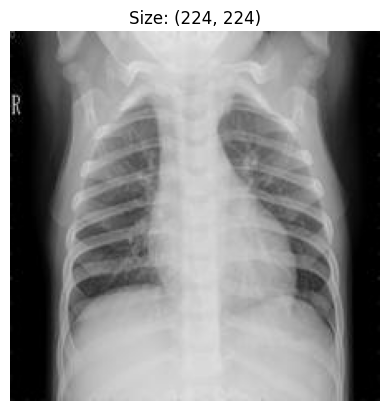

In [9]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Define the path to your resized dataset
resized_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'

# Pick a random image from test/NORMAL
sample_dir = os.path.join(resized_path, 'test/NORMAL')
sample_img = random.choice(os.listdir(sample_dir))
img_path = os.path.join(sample_dir, sample_img)

# Open and display the image
img = Image.open(img_path)
print("Size:", img.size)
plt.imshow(img)
plt.title(f"Size: {img.size}")
plt.axis('off')
plt.show()


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

# Step 1: Define preprocessing function
preprocess_fn = densenet_preprocess

# Step 2: Define ImageDataGenerators

# ✅ Training generator (with augmentation)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_fn,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# ✅ Validation and Test generator (no augmentation, just normalization)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_fn
)

# Step 3: Setup directory paths
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'

# Step 4: Create data generators
train_generator = train_datagen.flow_from_directory(
    directory=base_path + '/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    directory=base_path + '/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    directory=base_path + '/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for evaluation/prediction consistency
)


Found 5221 images belonging to 2 classes.
Found 1553 images belonging to 2 classes.
Found 1556 images belonging to 2 classes.


In [12]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Load the DenseNet121 base model
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 2. Freeze the base model layers (fine-tune later if needed)
base_model.trainable = False

# 3. Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

# 4. Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 5. Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_densenet121_model.h5', monitor='val_loss', save_best_only=True)
]

from PIL import Image, UnidentifiedImageError
import os




In [ ]:
def remove_corrupted_images(folder):
    removed = 0
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # Check if image is corrupted
                except (UnidentifiedImageError, OSError):
                    print(f"❌ Removing corrupted file: {file_path}")
                    os.remove(file_path)
                    removed += 1
    print(f"✅ Done. Removed {removed} corrupted files.")

# Path to your dataset
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
remove_corrupted_images(base_path)

In [13]:
import os

def count_images_by_class(base_path):
    splits = ['train', 'val', 'test']
    classes = ['PNEUMONIA', 'NORMAL']
    total_all = 0

    for split in splits:
        print(f"\n🔹 {split.upper()} SET:")
        total_split = 0
        for cls in classes:
            folder = os.path.join(base_path, split, cls)
            count = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"{cls}: {count}")
            total_split += count
        print(f"✅ Total in {split}: {total_split}")
        total_all += total_split

    print(f"\n🟢 Total images in all splits: {total_all}")

# Your dataset path
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
count_images_by_class(base_path)



🔹 TRAIN SET:
PNEUMONIA: 3818
NORMAL: 1403
✅ Total in train: 5221

🔹 VAL SET:
PNEUMONIA: 1135
NORMAL: 418
✅ Total in val: 1553

🔹 TEST SET:
PNEUMONIA: 1141
NORMAL: 415
✅ Total in test: 1556

🟢 Total images in all splits: 8330


In [18]:
from tensorflow.keras.models import load_model

# Path to uploaded file
model = load_model('/content/drive/MyDrive/TDenseNet121_checkpoint.h5')
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [14]:
# Re-import just in case
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

# Create fresh data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=densenet_preprocess,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=densenet_preprocess)

base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'

train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(base_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(base_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5221 images belonging to 2 classes.
Found 1553 images belonging to 2 classes.
Found 1556 images belonging to 2 classes.


In [23]:
import os
import pickle
import pandas as pd
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# ------------------ CONFIG ------------------ #
base_path = '/content/drive/MyDrive/Medical_Data/archive/chest_xray/chest_xray_split'
checkpoint_path = '/content/drive/MyDrive/TDenseNet121_checkpoint.h5'
final_model_path = '/content/drive/MyDrive/TDenseNet121_final.h5'
history_path = '/content/drive/MyDrive/TDenseNet121_history.pkl'
csv_log_path = '/content/drive/MyDrive/TDenseNet121_training_log.csv'

epochs = 15
batch_size = 32
input_shape = (224, 224, 3)

# ------------- DYNAMIC EPOCH RESUME ---------------- #
start_epoch = 0
if os.path.exists(csv_log_path):
    try:
        df = pd.read_csv(csv_log_path)
        start_epoch = int(df['epoch'].iloc[-1]) + 1
        print(f"🔁 Resuming from epoch {start_epoch}")
    except Exception as e:
        print(f"⚠️ Could not read CSV log: {e}")

# --------------- DATASET ------------------- #
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

train_datagen = ImageDataGenerator(
    preprocessing_function=densenet_preprocess,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=densenet_preprocess)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'val'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)

# ------------- LOAD OR CREATE MODEL -------------- #
if os.path.exists(checkpoint_path):
    print("📦 Loading model from checkpoint...")
    model = load_model(checkpoint_path)

    # ✅ IMPORTANT: Recompile to fix training error
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
else:
    print("🛠 Building new model...")
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# ------------- CALLBACKS ----------------- #
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

csv_logger = CSVLogger(csv_log_path, append=True)

# ------------- TRAIN --------------------- #
history = model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=start_epoch,
    epochs=epochs,
    callbacks=[checkpoint_callback, csv_logger]
)

# ------------- SAVE HISTORY -------------- #
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

# ------------- FINAL MODEL SAVE ---------- #
model.save(final_model_path)
print("✅ Final model saved:", final_model_path)


⚠️ Could not read CSV log: No columns to parse from file
Found 5221 images belonging to 2 classes.
Found 1553 images belonging to 2 classes.
🛠 Building new model...
Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6422 - loss: 0.8037 
Epoch 1: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 2374s 14s/step - accuracy: 0.6426 - loss: 0.8026 - val_accuracy: 0.9111 - val_loss: 0.3152
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7957 - loss: 0.4380
Epoch 2: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1171s 7s/step - accuracy: 0.7959 - loss: 0.4379 - val_accuracy: 0.8905 - val_loss: 0.2890
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8423 - loss: 0.3490
Epoch 3: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1175s 7s/step - accuracy: 0.8424 - loss: 0.3489 - val_accuracy: 0.9343 - val_loss: 0.2100
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8583 - loss: 0.3195
Epoch 4: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1255s 7s/step - accuracy: 0.8584 - loss: 0.3194 - val_accuracy: 0.9060 - val_loss: 0.2386
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8717 - loss: 0.2909
Epoch 5: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1168s 7s/step - accuracy: 0.8717 - loss: 0.2908 - val_accuracy: 0.9466 - val_loss: 0.1795
Epoch 6/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8825 - loss: 0.2798
Epoch 6: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1204s 7s/step - accuracy: 0.8825 - loss: 0.2798 - val_accuracy: 0.9221 - val_loss: 0.2039
Epoch 7/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8817 - loss: 0.2610
Epoch 7: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1196s 7s/step - accuracy: 0.8817 - loss: 0.2611 - val_accuracy: 0.9279 - val_loss: 0.1970
Epoch 8/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8890 - loss: 0.2702
Epoch 8: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1225s 7s/step - accuracy: 0.8890 - loss: 0.2701 - val_accuracy: 0.9266 - val_loss: 0.1969
Epoch 9/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9027 - loss: 0.2333
Epoch 9: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1199s 7s/step - accuracy: 0.9027 - loss: 0.2335 - val_accuracy: 0.9311 - val_loss: 0.1924
Epoch 10/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8955 - loss: 0.2490
Epoch 10: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1243s 7s/step - accuracy: 0.8955 - loss: 0.2489 - val_accuracy: 0.9343 - val_loss: 0.1809
Epoch 11/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8983 - loss: 0.2481
Epoch 11: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1210s 7s/step - accuracy: 0.8983 - loss: 0.2481 - val_accuracy: 0.9401 - val_loss: 0.1661
Epoch 12/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8973 - loss: 0.2541
Epoch 12: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1220s 7s/step - accuracy: 0.8974 - loss: 0.2539 - val_accuracy: 0.9221 - val_loss: 0.1988
Epoch 13/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9064 - loss: 0.2378
Epoch 13: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1205s 7s/step - accuracy: 0.9064 - loss: 0.2378 - val_accuracy: 0.9472 - val_loss: 0.1562
Epoch 14/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8952 - loss: 0.2406
Epoch 14: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1209s 7s/step - accuracy: 0.8952 - loss: 0.2406 - val_accuracy: 0.9459 - val_loss: 0.1644
Epoch 15/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9019 - loss: 0.2399
Epoch 15: saving model to /content/drive/MyDrive/TDenseNet121_checkpoint.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1223s 7s/step - accuracy: 0.9019 - loss: 0.2398 - val_accuracy: 0.9221 - val_loss: 0.1978


✅ Final model saved: /content/drive/MyDrive/TDenseNet121_final.h5


In [25]:
import pickle

# Load training history
with open('/content/drive/MyDrive/TDenseNet121_history.pkl', 'rb') as f:
    history = pickle.load(f)

final_train_acc = history['accuracy'][-1]
final_val_acc = history['val_accuracy'][-1]

print(f"✅ Final Training Accuracy: {final_train_acc*100:.2f}%")
print(f"✅ Final Validation Accuracy: {final_val_acc*100:.2f}%")


✅ Final Training Accuracy: 90.63%
✅ Final Validation Accuracy: 92.21%


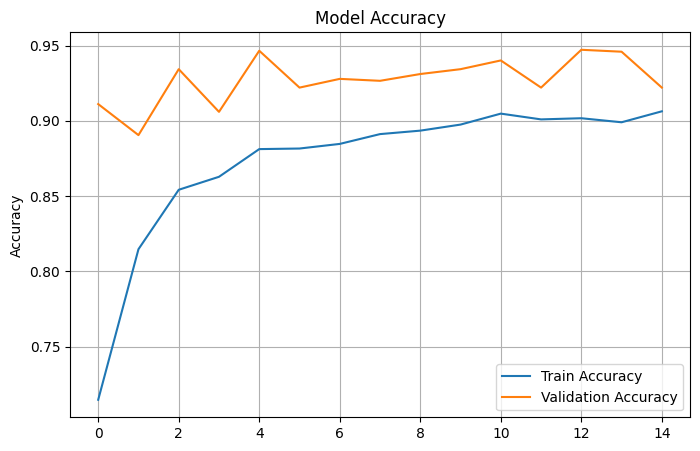

In [30]:
import matplotlib.pyplot as plt
import pickle

# Load history
with open('/content/drive/MyDrive/TDenseNet121_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')        # Updated title
plt.xlabel('')                     # No x-axis label
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


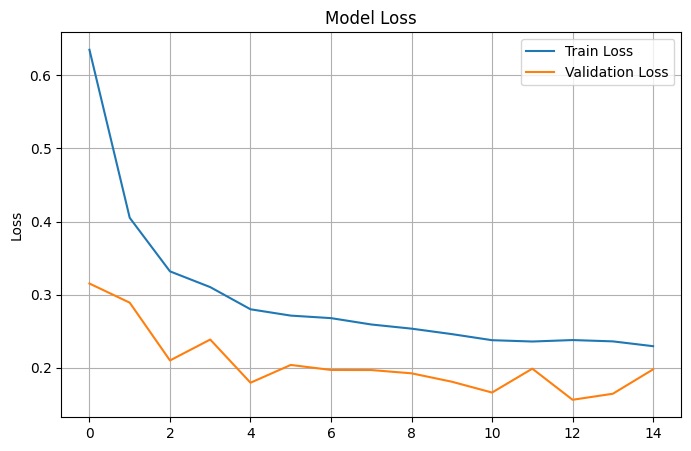

In [31]:
import matplotlib.pyplot as plt
import pickle

# Load history
with open('/content/drive/MyDrive/TDenseNet121_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')        # Title for loss
plt.xlabel('')                 # No x-axis label
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_accuracy*100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 631s 13s/step - accuracy: 0.9384 - loss: 0.1618
✅ Test Accuracy: 91.45%
📉 Test Loss: 0.1980


49/49 ━━━━━━━━━━━━━━━━━━━━ 265s 5s/step


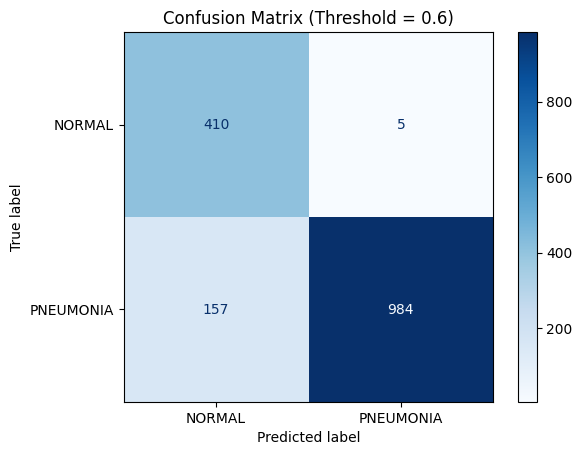

📊 Classification Metrics (Threshold = 0.90):

Accuracy       : 0.8959
Precision (0)  : 0.7231
Recall (0)     : 0.9880
F1 Score (0)   : 0.8350
Precision (1)  : 0.9949
Recall (1)     : 0.8624
F1 Score (1)   : 0.9239

🧮 Confusion Matrix Breakdown:
True Positives (TP): 984
True Negatives (TN): 410
False Positives (FP): 5
False Negatives (FN): 157


In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Get true labels
y_true = test_generator.classes

# Predict probabilities
y_pred_probs = model.predict(test_generator)

# Apply threshold of 0.90 instead of default 0.5
threshold = 0.60
y_pred = (y_pred_probs > threshold).astype(int).reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.grid(False)
plt.show()

# Classification report: only accuracy, precision, recall, f1
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

print("📊 Classification Metrics (Threshold = 0.90):\n")
print(f"Accuracy       : {report['accuracy']:.4f}")
print(f"Precision (0)  : {report[labels[0]]['precision']:.4f}")
print(f"Recall (0)     : {report[labels[0]]['recall']:.4f}")
print(f"F1 Score (0)   : {report[labels[0]]['f1-score']:.4f}")
print(f"Precision (1)  : {report[labels[1]]['precision']:.4f}")
print(f"Recall (1)     : {report[labels[1]]['recall']:.4f}")
print(f"F1 Score (1)   : {report[labels[1]]['f1-score']:.4f}")

# Confusion matrix values
tn, fp, fn, tp = cm.ravel()
print("\n🧮 Confusion Matrix Breakdown:")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 269s 5s/step
📊 Overall Model Performance (Threshold = 0.50):

✅ Accuracy : 0.9145
🎯 Precision: 0.9912
🔁 Recall   : 0.8913
📈 F1 Score : 0.9386


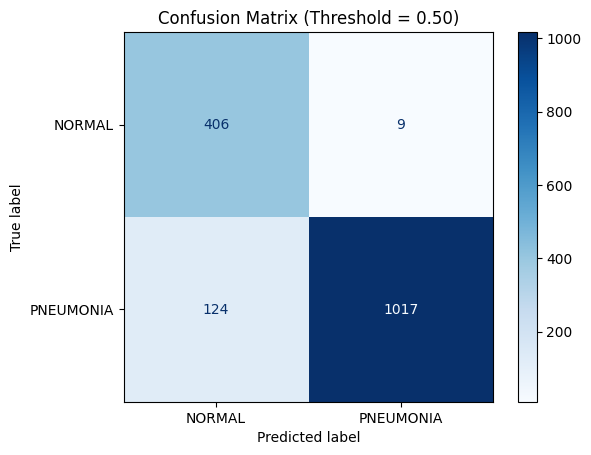


🧮 Confusion Matrix Breakdown:
✅ True Positives (TP): 1017
✅ True Negatives (TN): 406
❌ False Positives (FP): 9
❌ False Negatives (FN): 124


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get true labels from generator
y_true = test_generator.classes

# Step 2: Get model predictions (probabilities)
y_pred_probs = model.predict(test_generator)

# Step 3: Apply threshold of 0.50
threshold = 0.50
y_pred = (y_pred_probs > threshold).astype(int).reshape(-1)

# Step 4: Overall performance metrics
overall_accuracy  = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred)
overall_recall    = recall_score(y_true, y_pred)
overall_f1        = f1_score(y_true, y_pred)

# Step 5: Print metrics
print("📊 Overall Model Performance (Threshold = 0.50):\n")
print(f"✅ Accuracy : {overall_accuracy:.4f}")
print(f"🎯 Precision: {overall_precision:.4f}")
print(f"🔁 Recall   : {overall_recall:.4f}")
print(f"📈 F1 Score : {overall_f1:.4f}")

# Step 6: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())  # ['NORMAL', 'PNEUMONIA']

# Step 7: Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Threshold = 0.50)")
plt.grid(False)
plt.show()

# Step 8: Extract TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()

print("\n🧮 Confusion Matrix Breakdown:")
print(f"✅ True Positives (TP): {tp}")
print(f"✅ True Negatives (TN): {tn}")
print(f"❌ False Positives (FP): {fp}")
print(f"❌ False Negatives (FN): {fn}")
